# Анализ данных сервиса аренды самокатов GoFast

## Описание проекта
Проект по анализу данных популярного сервиса аренды самокатов GoFast. Данные содержат информацию о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться как с подпиской, так и без неё.

Нужно провести анализ данных и проверить ряд гипотез, которые могут помочь бизнесу вырасти.


In [210]:
# Импорты
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import binom, norm
from matplotlib import pyplot as plt

In [211]:
# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## Загрузка данных

In [212]:
try:
    # Практикум
    users_original_df = pd.read_csv('/datasets/users_go.csv')
    rides_original_df = pd.read_csv('/datasets/rides_go.csv')
    subs_original_df = pd.read_csv('/datasets/subscriptions_go.csv')
    display('Датасеты из Практикума загружены.')
except:
    # Локальный проект
    users_original_df = pd.read_csv('datasets/users_go.csv')
    rides_original_df = pd.read_csv('datasets/rides_go.csv')
    subs_original_df = pd.read_csv('datasets/subscriptions_go.csv')
    display('Локальные датасеты загружены.')

'Локальные датасеты загружены.'

**Users:**
* `user_id`	- уникальный идентификатор пользователя
* `name` - имя пользователя
* `age` - возраст
* `city` - город
* `subscription_type` - тип подписки (free, ultra)

In [213]:
users_original_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [214]:
users_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**Rides:**
* `user_id` - уникальный идентификатор пользователя
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` - дата совершения поездки

In [215]:
rides_original_df.head()

,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


In [216]:
rides_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


**Subscriptions:**
* `subscription_type` - тип подписки
* `minute_price` - стоимость одной минуты поездки по данной подписке
* `start_ride_price` - стоимость начала поездки
* `subscription_fee` - стоимость ежемесячного платежа

In [217]:
subs_original_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [218]:
subs_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Выводы по предварительному изучению данных:**
* Во всех датасетах отсутствуют пропуски.
* Все типы, кроме date определились корректно.
* Названия столбцов в порядке.

## Предобработка данных

In [219]:
# Делаем копии рабочих датасетов.
users_df = users_original_df.copy()
rides_df = rides_original_df.copy()
subs_df = subs_original_df.copy()

In [220]:
# Смотрим на прямые дубликаты.
display('Дубликатов в users: ' + str(users_df.duplicated().sum()))
display('Дубликатов в rides: ' + str(rides_df.duplicated().sum()))

'Дубликатов в users: 31'

'Дубликатов в rides: 0'

In [221]:
# Убираем дубликаты в users, эти данные не несут никакой смысловой нагрузки.
display(users_df.shape)
users_df.drop_duplicates(inplace=True)
display(users_df.shape)

(1565, 5)

(1534, 5)

In [222]:
# Преобразуем date в rides в datetime.
display(rides_df['date'].head())
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')
display(rides_df['date'].head())

0    2021-01-01
1    2021-01-18
2    2021-04-20
3    2021-08-11
4    2021-08-28
Name: date, dtype: object

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [223]:
# Создаём дополнительный столбец в rides с указанием месяца поездки.
rides_df['month'] = rides_df['date'].dt.month
rides_df[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


Поищем непрямые дубликаты в данных.

In [224]:
users_df['city'].unique()  # С городами всё хорошо.

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [225]:
users_df['user_id'].duplicated().sum()  # Дублей в id пользователей нет.

0

In [226]:
users_df['age'].describe()  # С возрастом всё хорошо. Пассажиры от 12 до 43 лет.

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

In [227]:
users_df['subscription_type'].value_counts()  # Всё хорошо.

free     835
ultra    699
Name: subscription_type, dtype: int64

**Выводы по предобработке данных:**
* Удалены дубли по пользователям в количестве 31 штука.
* Преобразован тип в столбце date на datetime и добавлен столбец с указанием месяца поездки.
* В остальном данные особой предобработки не требуют.

## Исследовательский анализ данных

In [228]:
# Изучим города, в которых пользователи используют сервис.
users_df['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

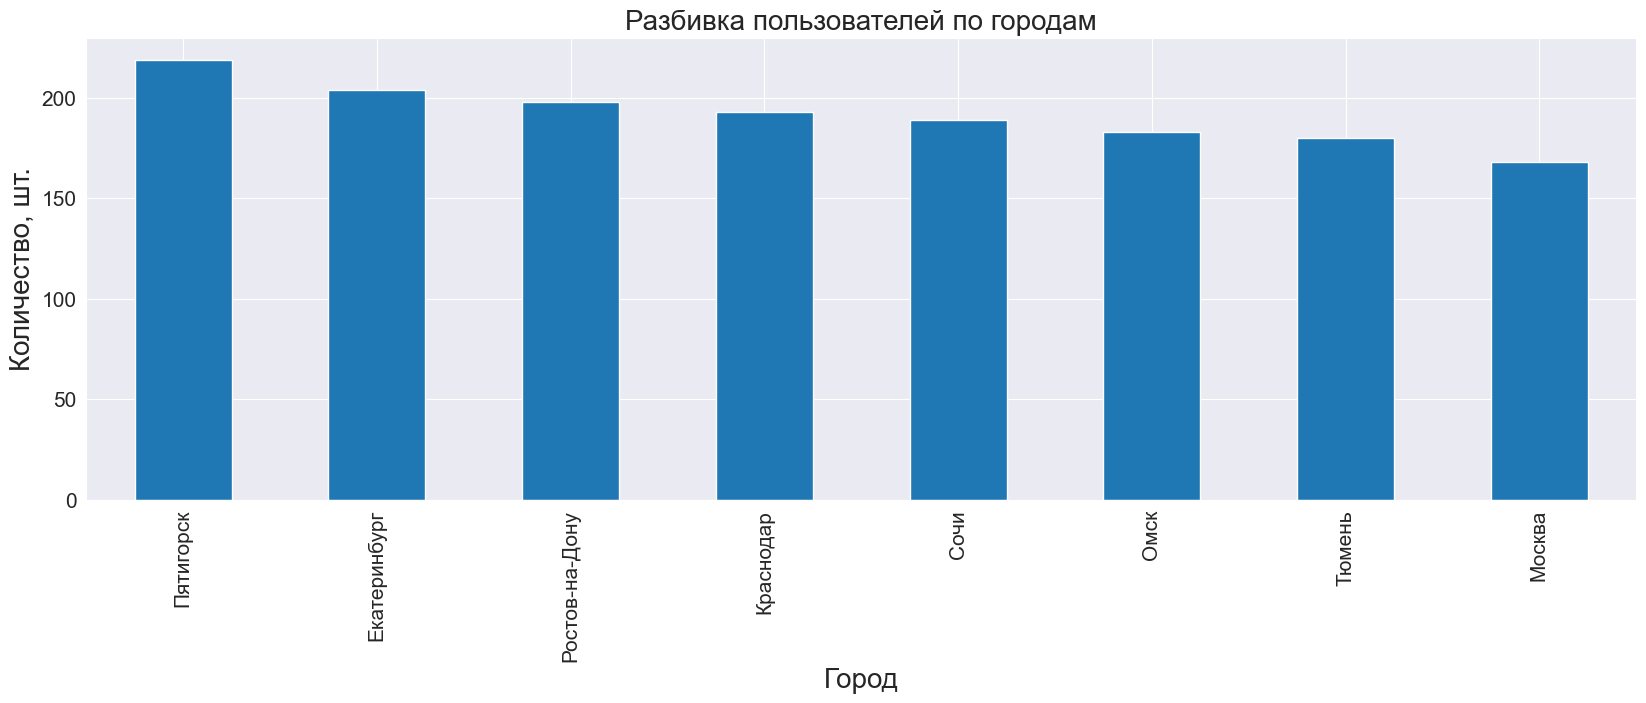

In [229]:
fig, ax = plt.subplots()
ax.set_title('Разбивка пользователей по городам', fontsize=20)
ax.set_xlabel('Город', fontsize=20)
ax.set_ylabel('Количество, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
users_df['city'].value_counts().plot.bar(figsize=(20, 6), grid=True)
plt.show()

**Города:**
* Больше всего в исследуемой выборке пользователей из Пятигорска. Меньше всего из Москвы.
* Каждый город представлен более-менее равномерно, вне зависимости от размеров.

In [230]:
# Подписки.
display(users_df['subscription_type'].value_counts())
users_df.groupby(['city', 'subscription_type'])['subscription_type'].count()

free     835
ultra    699
Name: subscription_type, dtype: int64

city            subscription_type
Екатеринбург    free                 112
                ultra                 92
Краснодар       free                 112
                ultra                 81
Москва          free                  84
                ultra                 84
Омск            free                  92
                ultra                 91
Пятигорск       free                 125
                ultra                 94
Ростов-на-Дону  free                 109
                ultra                 89
Сочи            free                 103
                ultra                 86
Тюмень          free                  98
                ultra                 82
Name: subscription_type, dtype: int64

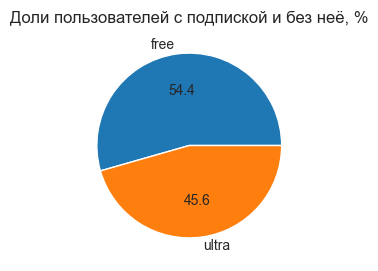

In [231]:
fig, ax = plt.subplots()
ax.set_title('Доли пользователей с подпиской и без неё, %')
users_df['subscription_type'].value_counts().plot.pie(figsize=(20, 3), autopct='%.1f')
ax.set_ylabel(None)
plt.show()

**Подписки:**
* В выборке представлены в большом количестве как пользователи с подпиской, так и без по каждому из городов.
* Пользователей с подпиской немного меньше бесплатных пользователей.

In [232]:
# Возраст пользователей.
users_df['age'].describe()

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

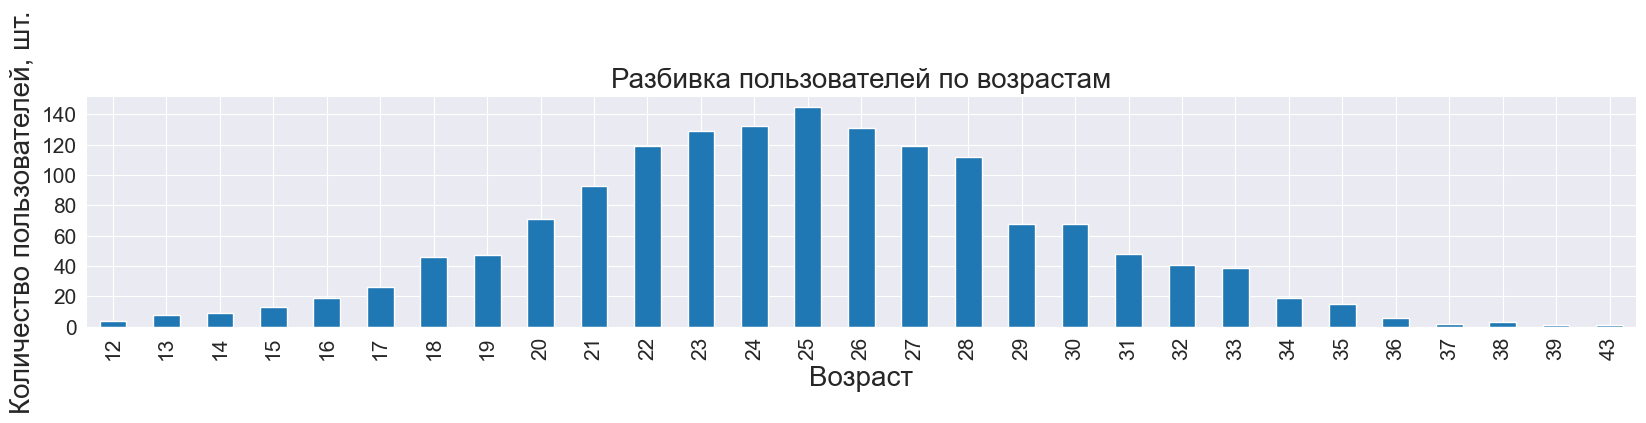

In [233]:
fig, ax = plt.subplots()
ax.set_title('Разбивка пользователей по возрастам', fontsize=20)
ax.set_xlabel('Возраст', fontsize=20)
ax.set_ylabel('Количество пользователей, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
users_df['age'].value_counts().sort_index().plot.bar(figsize=(20, 3))
plt.show()

**Возраст:**
* В выборке представлены пользователи от 12 до 43 лет.
* Средний/медианный возраст пользователей ~25 лет.

In [234]:
# Продолжительность и дальность поездок.
rides_df[['distance', 'duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,18068.00,3070.66,1116.83,0.86,2543.23,3133.61,3776.22,7211.01
duration,18068.00,17.81,6.09,0.50,13.60,17.68,21.72,40.82


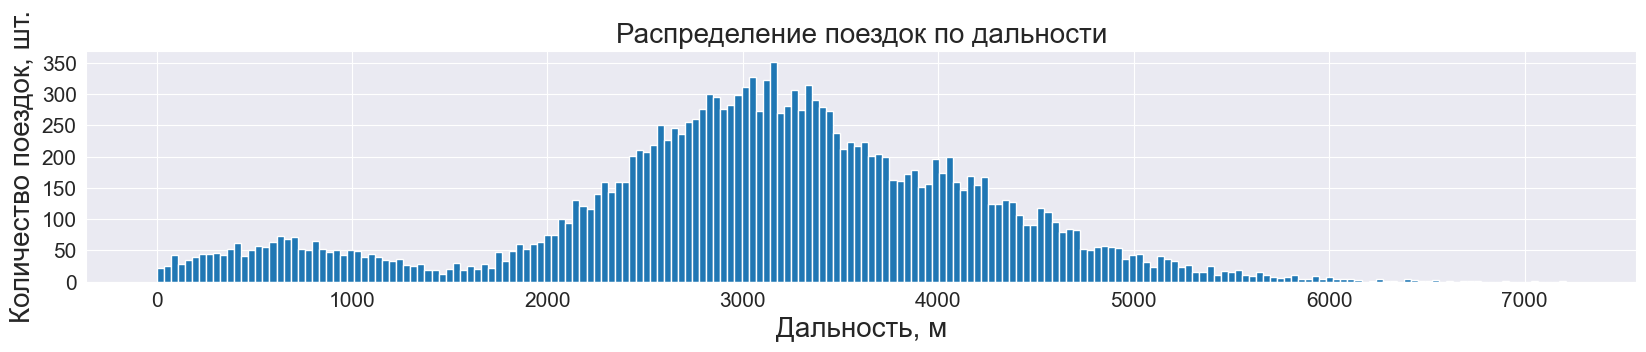

In [235]:
# Визуальный осмотр дальности.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок по дальности', fontsize=20)
ax.set_xlabel('Дальность, м', fontsize=20)
ax.set_ylabel('Количество поездок, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rides_df['distance'].hist(bins=200, figsize=(20, 3), ax=ax);

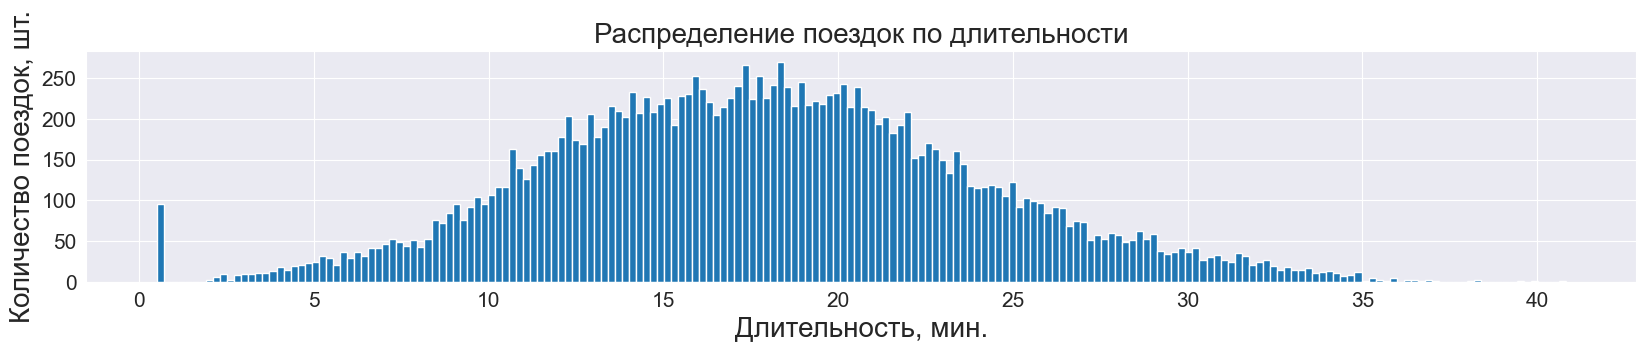

In [236]:
# Визуальный осмотр длительности.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок по длительности', fontsize=20)
ax.set_xlabel('Длительность, мин.', fontsize=20)
ax.set_ylabel('Количество поездок, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rides_df['duration'].hist(bins=200, figsize=(20, 3), ax=ax);

'Количество поездок до 100 метров: 78'

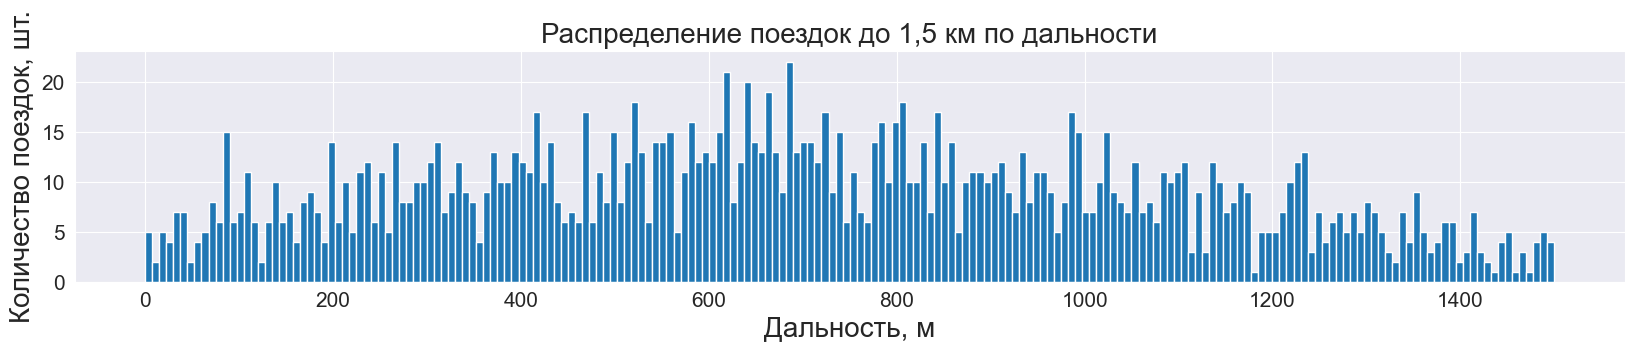

In [237]:
# Поездки до 1,5 км.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок до 1,5 км по дальности', fontsize=20)
ax.set_xlabel('Дальность, м', fontsize=20)
ax.set_ylabel('Количество поездок, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rides_df['distance'].hist(ax=ax, bins=200, figsize=(20, 3), range=(0, 1500))
"Количество поездок до 100 метров: " + str(rides_df.query('distance < 100').shape[0])

**Дальность поездки:**
* Средняя дальность поездки составляет около 3,1 км. Максимальная - 7,2 км. Вполне реалистично.
* Распределение поездок по дальности имеет 2 ярко-выраженных пика. Один в районе 0,8 км (короткие поездки), другой в районе 3,1 км (нормальные поездки).
* Часть поездок - ультракороткие. 78 поездок до 100 метров. Вероятно - это случаи когда новые пользователи только знакомились с возможностями самокатов.

'Количество поездок продолжительностью до 1 минуты: 95'

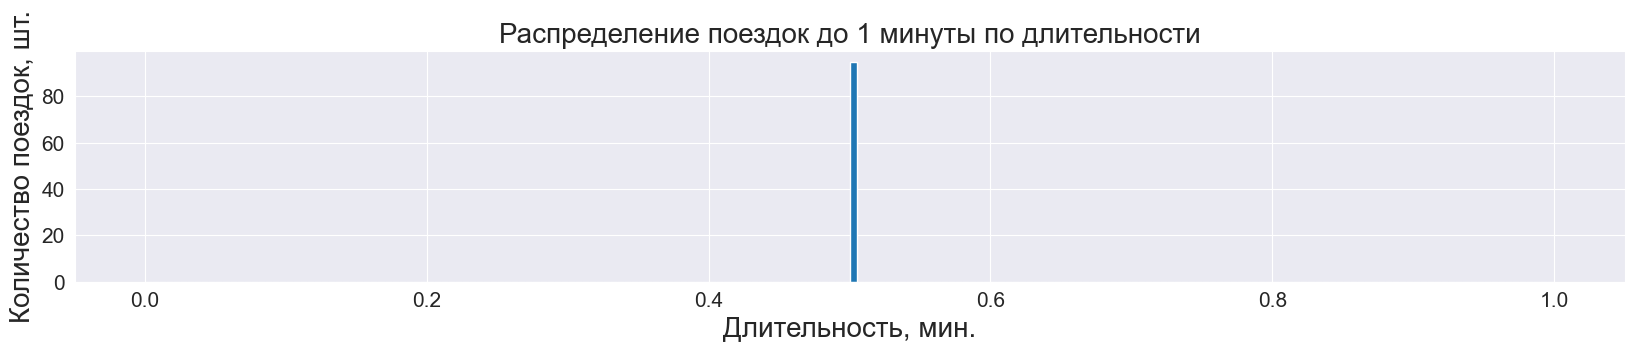

In [238]:
# Поездки до 1 минуты.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок до 1 минуты по длительности', fontsize=20)
ax.set_xlabel('Длительность, мин.', fontsize=20)
ax.set_ylabel('Количество поездок, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rides_df['duration'].hist(bins=200, figsize=(20, 3), range=(0, 1), ax=ax)
'Количество поездок продолжительностью до 1 минуты: ' + str(rides_df.query('duration < 1').shape[0])

In [239]:
# Посмотрим на поездки до 1 минуты.
rides_df.query('duration < 1').describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,95.00,1092.21,244.03,701.00,901.00,1069.00,1310.50,1524.00
distance,95.00,5113.18,658.25,4030.31,4611.51,5052.77,5488.46,7211.01
duration,95.00,0.50,0.00,0.50,0.50,0.50,0.50,0.50
month,95.00,6.48,3.71,1.00,3.00,6.00,10.00,12.00


95

,user_id,distance,duration,date,month
6531,701,4196.45,NaN,2021-08-31,8
6570,704,4830.82,NaN,2021-10-14,10
6680,712,4684.00,NaN,2021-03-04,3
6695,713,5215.64,NaN,2021-02-25,2
6768,718,5197.44,NaN,2021-02-11,2


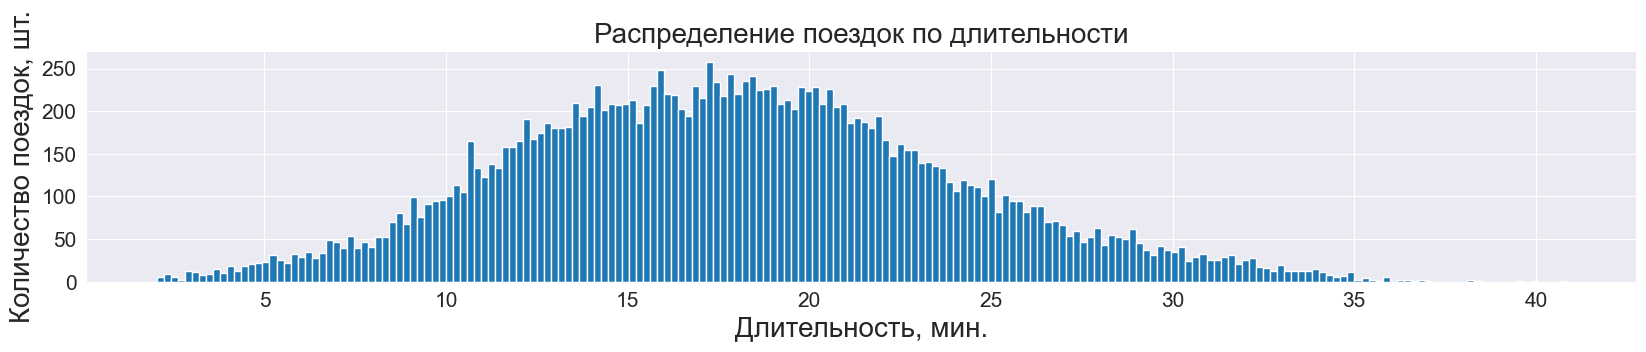

In [240]:
# Заменим поездки длительностью 0,5 минуты пропусками.
rides_df.loc[rides_df['duration'] < 1, ['duration']] = float('nan')
display(rides_df['duration'].isna().sum())

# Взглянем на распределение еще раз.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок по длительности', fontsize=20)
ax.set_xlabel('Длительность, мин.', fontsize=20)
ax.set_ylabel('Количество поездок, шт.', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rides_df['duration'].hist(bins=200, figsize=(20, 3), ax=ax)

rides_df[rides_df['duration'].isna()].head()

**Продолжительность поездки:**
* Средняя продолжительность поездки на самокате около 18 минут. Самая долгая поездка - 41 минута.
* В данных есть 95 поездок длительностью ровно полминуты и с дистанцией от 4 до 7 км. Это явно ошибочные данные. Ввиду того, что 95 поездок может составлять до половины поездок по конкретному городу, а пока понять разбивку этих поездок по городам мы понять не можем - была сделана замена длительностей этих поездок на na. **Необходимо провести коммуникации с предоставившими данные сотрудниками.**

## Объединение данных

In [241]:
# На основе rides собираем данные в один датафрейм.
df = rides_df.merge(users_df, how='left', on='user_id').merge(subs_df, how='left', on='subscription_type')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [242]:
free_df = df.query('subscription_type == "free"')
ultra_df = df.query('subscription_type == "ultra"')

In [243]:
# Проверки
display('Начальное количество строк: ' + str(rides_df.shape[0]))
display('Итоговое количество строк: ' + str(df.shape[0]))
display('Разделение на датафреймы прошло верно: ' + str(df.shape[0] == free_df.shape[0] + ultra_df.shape[0]))

'Начальное количество строк: 18068'

'Итоговое количество строк: 18068'

'Разделение на датафреймы прошло верно: True'

In [244]:
# Анализ расстояний и времени поездок по free
free_df[['distance', 'duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,11568.00,3045.50,1246.17,0.86,2366.56,3114.65,3905.70,7211.01
duration,11473.00,17.53,6.16,2.04,13.09,17.38,21.64,34.95


In [245]:
# Анализ расстояний и времени поездок по ultra
ultra_df[['distance', 'duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,6500.00,3115.45,836.90,244.21,2785.44,3148.64,3560.57,5699.77
duration,6500.00,18.54,5.57,3.76,14.52,18.18,21.88,40.82


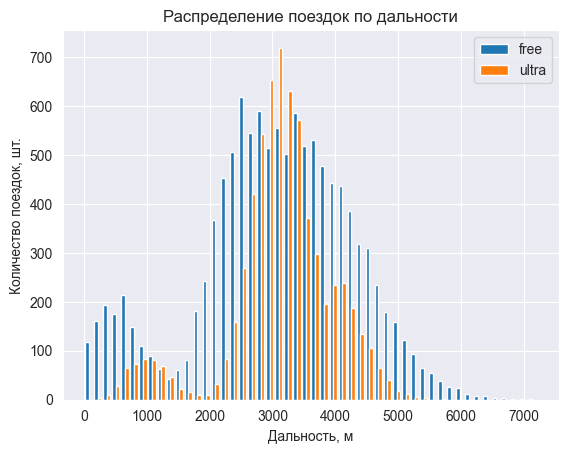

In [246]:
# Сравним распределения по дальности для free и ultra.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок по дальности')
ax.set_xlabel('Дальность, м')
ax.set_ylabel('Количество поездок, шт.')
plt.hist([free_df['distance'], ultra_df['distance']], bins = 50, label=['free', 'ultra'])
plt.legend()
plt.show()

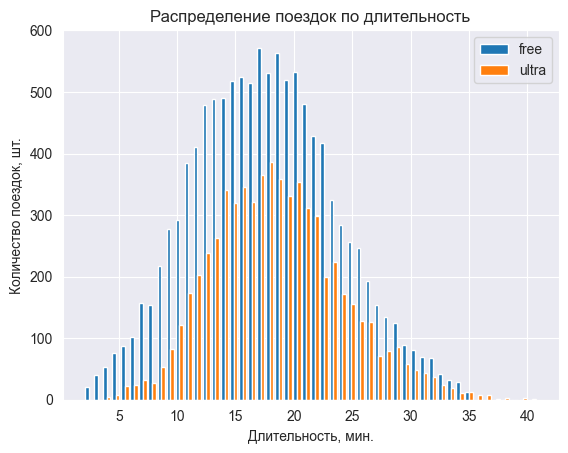

In [247]:
# Сравним распределения по длительности для free и ultra.
fig, ax = plt.subplots()
ax.set_title('Распределение поездок по длительность')
ax.set_xlabel('Длительность, мин.')
ax.set_ylabel('Количество поездок, шт.')
plt.hist([free_df['duration'], ultra_df['duration']], bins = 50, label=['free', 'ultra'])
plt.legend()
plt.show()

**Выводы по distance и duration в зависимости от статуса пользователей:**
* Премиум пользователи совершают меньше коротких (до километра) поездок. При этом чаще прочих совершают поездки дальностью около 4км (пока не ясно в связи с чем).
* Дисперсия по расстоянию поездки у премиум пользователей меньше.
* В среднем дальность поездки у пользователей с разным статусом примерно одинакова.
* Средняя продолжительность поездки у премиум-пользователей не сильно отличается от пользователей с бесплатным тарифом.

## Подсчёт выручки

In [248]:
# Создаём таблицу с группировкой по юзерам и месяцам, подтягиваем subs_type и делаем расчёт для времени оплаты.
agg_by_user_and_month_df = df.groupby(['user_id', 'subscription_type', 'month']).agg(
    {'distance': ['sum', 'count'], 'duration': ['sum', lambda x: np.ceil(x).sum()]})
# Заменяем комплексный индекс на обычный и обновляем названия столбцов.
agg_by_user_and_month_df.reset_index(drop=False, inplace=True)
agg_by_user_and_month_df.columns = ['user_id', 'subscription_type', 'month', 'distance_sum', 'rides_count',
                                    'duration_sum', 'duration_ceiled_sum']
agg_by_user_and_month_df.head()

,user_id,subscription_type,month,distance_sum,rides_count,duration_sum,duration_ceiled_sum
0,1,ultra,1,7027.51,2,41.42,42.00
1,1,ultra,4,754.16,1,6.23,7.00
2,1,ultra,8,6723.47,2,44.78,46.00
3,1,ultra,10,5809.91,2,31.58,32.00
4,1,ultra,11,7003.50,3,53.40,56.00


In [249]:
# Сохраняем тариф в переменные
minute_price_free = subs_original_df[subs_original_df['subscription_type'] == 'free']['minute_price'][0]
minute_price_ultra = subs_original_df[subs_original_df['subscription_type'] == 'ultra']['minute_price'][1]
start_ride_price_free = subs_original_df[subs_original_df['subscription_type'] == 'free']['start_ride_price'][0]
start_ride_price_ultra = subs_original_df[subs_original_df['subscription_type'] == 'ultra']['start_ride_price'][1]
subs_fee_free = subs_original_df[subs_original_df['subscription_type'] == 'free']['subscription_fee'][0]
subs_fee_ultra = subs_original_df[subs_original_df['subscription_type'] == 'ultra']['subscription_fee'][1]

# Пишем функцию для расчёта выручки.
def revenue_calculator(s):
    if s['subscription_type'] == 'free':
        return subs_fee_free + s['duration_ceiled_sum'] * minute_price_free + s['rides_count'] * start_ride_price_free
    else:
        return subs_fee_ultra + s['duration_ceiled_sum'] * minute_price_ultra + s[
            'rides_count'] * start_ride_price_ultra

In [250]:
# Применяем функцию для расчёта выручки
agg_by_user_and_month_df['revenue'] = agg_by_user_and_month_df.apply(revenue_calculator, axis='columns')

agg_by_user_and_month_df.groupby('subscription_type')['revenue'].mean()

subscription_type
free    328.53
ultra   362.79
Name: revenue, dtype: float64

**Выводы:**
* Произведен расчёт выручки помесячно для каждого пользователя.
* Премиальные пользователи в среднем в месяц приносят больше выручки, чем бесплатные.

## Проверка гипотез

**Н0:** Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.
**Н1:** Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [251]:
alpha = 0.01
result = st.ttest_ind(ultra_df['duration'].dropna(), free_df['duration'].dropna(), alternative='greater')
display('Pvalue:' + str(result.pvalue))
if result.pvalue > alpha:
    display('Нет оснований отвергать нулевую гипотезу.')
else:
    display('Отвергаем нулевую гипотезу.')

'Pvalue:4.7044680744539e-28'

'Отвергаем нулевую гипотезу.'

**Вывод:**
* Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

**Н0:** Среднее расстояние, которое за одну поездку проезжают пользователи с подпиской равно 3130 метров.
**Н1:** Среднее расстояние, которое за одну поездку проезжают пользователи с подпиской более 3130 метров.

In [252]:
alpha = 0.01
mean_dist = 3130
result = st.ttest_1samp(ultra_df['distance'].dropna(), mean_dist, alternative='greater')
display('Pvalue:' + str(result.pvalue))
if result.pvalue > alpha:
    display('Нет оснований отвергать нулевую гипотезу.')
else:
    display('Отвергаем нулевую гипотезу.')

'Pvalue:0.9195368847849785'

'Нет оснований отвергать нулевую гипотезу.'

**Вывод:**
* Нет оснований полагать, что среднее расстояние, которое за одну поездку проезжают пользователи с подпиской больше 3130 метров.

**Н0:** Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.
**Н1:** Средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручке от пользователей без подписки.

In [253]:
alpha = 0.01
result = st.ttest_ind(
    agg_by_user_and_month_df[agg_by_user_and_month_df['subscription_type'] == 'ultra']['revenue'].dropna(),
    agg_by_user_and_month_df[agg_by_user_and_month_df['subscription_type'] == 'free']['revenue'].dropna(),
    alternative='greater')
display('Pvalue:' + str(result.pvalue))
if result.pvalue > alpha:
    display('Нет оснований отвергать нулевую гипотезу.')
else:
    display('Отвергаем нулевую гипотезу.')

'Pvalue:1.2340971814820165e-31'

'Отвергаем нулевую гипотезу.'

**Выводы:**
* Средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручки от пользователей без подписки.

**Проверка гипотезы о снижении обращений в техподдержку:**
* Для проверки такой гипотезы потребуется проверка гипотезы равенства среднего по парным выборкам.
* Необходимо будет использовать тест scipy.stats.ttest_rel(before, after).

## Распределения

**Задача:**
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей.

Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

'Вероятность получить меньше 100 дополнительных подписчиков при раздаче 1172 промокодов составляет: 4.95%'

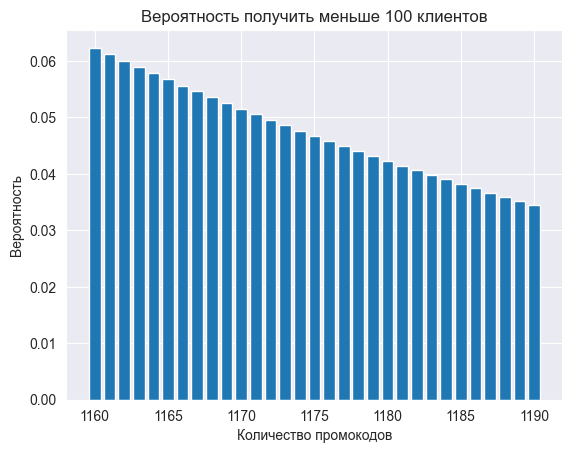

In [254]:
# Необходимо построить биномиальное распределение.
p = 0.1
new_clients_required = 100
# Диапазон для графика.
n_min= 1160
n_max = 1190
p_plan = 0.05

dots = []

# Строим график вероятности получить меньше 100 клиентов.
for i in range(n_min, n_max + 1):
    dots.append(binom.cdf(new_clients_required, i, p))

fig, ax = plt.subplots()
ax.set_title('Вероятность получить меньше 100 клиентов')
ax.set_ylabel('Вероятность')
ax.set_xlabel('Количество промокодов')
plt.bar(range(n_min, n_max + 1), dots)

# Определяем на глаз значение под p_plan.
display(f'Вероятность получить меньше 100 дополнительных подписчиков при раздаче 1172 промокодов составляет: {binom.cdf(new_clients_required, 1172, p):.2%}')

**Вывод:** Для получения минимум 100 новых подписчиков с вероятностью более 95% необходимо раздать минимум 1172 промокода.

**Задача:**
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [255]:
# Параметры биномиального распределения
p = 0.4
n = 10 ** 6
mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

# Проверим диапазон mu +- 3 *sigma.
display('Можно аппроксимировать нормальным распределением?', (mu - 3 * sigma > 0), (mu + 3 * sigma < n))

distr = norm(mu, sigma)

new_clients_required = 399_500
new_clients_required_for_norm = (399_500 - mu) / sigma

display(f'Вероятность получить менее 399,5 тыс. открытых уведомлений: {norm.cdf(new_clients_required_for_norm):.2%}')

'Можно аппроксимировать нормальным распределением?'

True

True

'Вероятность получить менее 399,5 тыс. открытых уведомлений: 15.37%'

**Вывод:** Вероятность получить менее 399,5 тыс. открытых уведомлений составляет 15,37%.

## Выводы по проекту
* Во время работы проведена обработка и анализ предоставленных сервисом данных.
* Выявлен предположительно ряд ошибочных данных по продолжительности поездки в размере 95 семплов. Команде сервиса рекомендуется выяснить по какой причине появились странные значения длительности поездок ровно 0.5 минуты.
* Выборка довольно равномерно распределена по 8 городам, пользователям с подпиской и без. Средний возраст пользователей составляет около 25 лет. Среди поездок можно выделить 2 группы: короткие (до 1,5 км) и дальние (до 7,5 км). Средняя поездка составляет около 18 минут.
* Средняя продолжительность и дальность поездок пользователей с премиальным аккаунтом и непремиальным отличаются несильно.
* Расчёт помесячной выручки для пользователей показал, что премиальные пользователи в среднем в месяц приносят больше выручки, чем бесплатные.
* Проверка гипотез привела к следующим выводам:
    * Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
    * Нет оснований полагать, что среднее расстояние, которое за одну поездку проезжают пользователи с подпиской больше 3130 метров.
    * Средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручки от пользователей без подписки.
* **Таким образом, статистически обоснован вывод о том, что премиальные подписчики являются более выгодными клиентами для компании, чем беслатные подписчики.**
* В завершающей части работы проведено изучение 2 биномиальных распределений в рамках которых решены 2 задачи.